## Teaching Machines to Understand What They See
by [Semih Yagcioglu](http://semihyagcioglu.com)

This is a tutorial for the talk I gave at PyData Istanbul. We will build a Convolutional Neural Network to classify images in CIFAR10 dataset, make predictions with the trained model visualize these results as well as the learned weights of the model. You can find more details about the tutorial [here](http://semihyagcioglu.com/talks/teaching-machines-to-see).

### Imports

In [37]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import time
from datetime import timedelta
import math
import os
import pandas as pd

from keras.datasets import cifar10
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.layers.normalization import BatchNormalization
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adadelta, Adagrad, Adam
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend as k
from keras import applications

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
k.set_image_dim_ordering('tf')

# set seed for reproducibility
seed = 1337
np.random.seed(seed)

### Loading the Data

The CIFAR-10 data-set has now been loaded and consists of 60,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [11]:
def load_dataset(validation_size):
    # the data, shuffled and split between train and test sets
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
    y_test_labels = y_test # store the original labels as we will use them later
    y_train_labels = y_train
    y_test_labels = np.reshape(y_test_labels, (y_test_labels.shape[0]))
    y_train_labels = np.reshape(y_train_labels, (y_train_labels.shape[0]))
    
    nb_classes = len(list(set(y_test_labels)))
    
    # convert class vectors to binary class matrices
    y_train = np_utils.to_categorical(y_train, nb_classes)
    y_test = np_utils.to_categorical(y_test, nb_classes)
    
    # normalize inputs from 0-255 to 0.0-1.0
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    # hold some part of training set for validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=100)
 
    return X_train, y_train, X_val, y_val, X_test, y_test, y_test_labels, y_train_labels


# load the dataset with train, val and test splits, use 10% of train set as validation set
X_train, y_train, X_val, y_val, X_test, y_test, y_test_labels, y_train_labels = load_dataset(validation_size = 0.1)

print("Size of:")
print("- Trainining-set:\t{}".format(X_train.shape[0]))
print("- Validation-set:\t{}".format(X_val.shape[0]))
print("- Test-set:\t\t{}".format(X_test.shape[0]))

Size of:
- Trainining-set:	45000
- Validation-set:	5000
- Test-set:		10000


### Looking at the Dataset Statistics

In [12]:
# fix: get these from the dataset!
class_names = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

class_labels = list(set(y_test_labels))

y_train_counts = {}
for label in y_train_labels:
    if label not in y_train_counts:
        y_train_counts[label] = 1
    else:
        y_train_counts[label] += 1
        
print("Groundtruth Statistics:")

print()

for key, value in y_train_counts.iteritems():
    print("Class %d (%s) \t%d" % (key, class_names[key], value))
    
max_val = max(y_train_counts.values())
baseline = max_val * 100.0 / sum(y_train_counts.values())

print()
print("Baseline: %.2f%%" % baseline)

Groundtruth Statistics:

Class 0 (airplane) 	5000
Class 1 (automobile) 	5000
Class 2 (bird) 	5000
Class 3 (cat) 	5000
Class 4 (deer) 	5000
Class 5 (dog) 	5000
Class 6 (frog) 	5000
Class 7 (horse) 	5000
Class 8 (ship) 	5000
Class 9 (truck) 	5000

Baseline: 10.00%


### Setting the Hyperparameters

In [38]:
# hyperparameters
model_filename = 'model_architecture.json'
model_weights_filename = 'model_weights.h5'
load_model = True  # make it True if you wan't to load from a pre-trained model 

nb_classes = len(class_labels)
batch_size = 256
epochs = 2
nb_filter = 32

(img_rows, img_cols, img_channels) = X_train.shape[1:] # height, width, channels 

lrate = 0.01
decay = lrate/epochs
momentum = 0.9 # for sgd
data_augmentation = False
# sigma = 0.01
# l1_weight = 0.01
# l2_weight = 0.05
# l1_activation = 0.05
# l2_activation = 0.05

# print (img_rows, img_cols, img_channels)

### Build a Network with the Given Hyperparameters

In [45]:
def load_model_from_file(model_filename, model_weights_filename):
    
    loaded_model = None
    
    with open(model_filename, 'r') as json_file: # load json and create model
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        loaded_model.load_weights(model_weights_filename) # load weights into new model
        print("Loaded model from disk")
        
    return loaded_model

def create_network(img_rows, img_cols, img_channels):
    
    model = Sequential()
    
    model.add(Conv2D(nb_filter, (3, 3), input_shape=(img_rows, img_cols, img_channels), activation='relu'))
    model.add(Conv2D(nb_filter, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(nb_filter*2, (3, 3), activation='relu'))
    model.add(Conv2D(nb_filter*2, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(nb_classes, activation='softmax'))

    return model


# define optimizer
sgd = SGD(lr=lrate, momentum=momentum, decay=decay, nesterov=False)
adam = Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
optimizer = sgd # you can also set this to another optimizer such as adam

loss = 'categorical_crossentropy'

if load_model == True:
    model = load_model_from_file(model_filename, model_weights_filename)
    if model is None: # in case there is no file with the given name, create the network from scratch
        model = create_network(img_rows, img_cols, img_channels)
else:
    model = create_network(img_rows, img_cols, img_channels)
    
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)      

### Train the Model

You can skip this step if you wan't to evaluate the model with the pretrained model or else re-train your network.


In [10]:
# monitor validation loss and stop if it does not improve for sometime
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto')

# fit the model
res = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, 
                callbacks=[], shuffle=False, verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/2
45000/45000 [==============================] - 320s - loss: 1.6862 - acc: 0.3894 - val_loss: 1.9892 - val_acc: 0.3442
Epoch 2/2
45000/45000 [==============================] - 277s - loss: 1.3313 - acc: 0.5237 - val_loss: 1.5869 - val_acc: 0.4974


### Plot the Training Performance

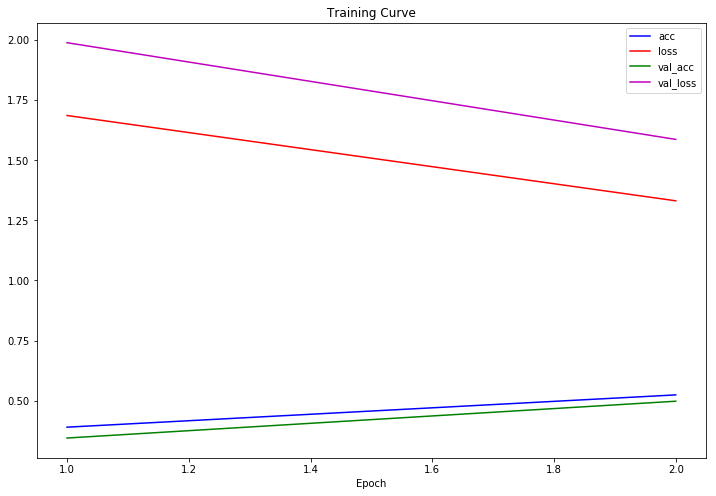

In [40]:
hist = res.history
colors = {'loss':'r', 'acc':'b', 'val_loss':'m', 'val_acc':'g'}
plt.figure(figsize=(12,8))
plt.title("Training Curve") 
plt.xlabel("Epoch")

for measure in hist.keys():
    color = colors[measure]
    plt.plot(range(1,epochs+1), hist[measure], color + '-', label=measure)  # use last 2 values to draw line

plt.legend(loc='upper right', scatterpoints = 1, frameon=True);

### Save Model Architecture and Model Weights

In [43]:
def save_model(model, model_filename, model_weights_filename):
    model_json = model.to_json() # serialize model to JSON
    with open(model_filename, 'w')as json_file:
        json_file.write(model_json)
        
    model.save_weights(model_weights_filename, overwrite=True) # serialize weights to HDF5
    print("Saved model to disk")
    
save_model(model, model_filename, model_weights_filename)

Saved model to disk


### Evaluate the Model Using the Test Set

In [46]:
# evaluate the model on test set
scores = model.evaluate(X_test, y_test, verbose=1)
print()
print("Accuracy: %.2f%%" % (scores[1]*100))

 9984/10000 [============================>.] - ETA: 0s
Accuracy: 49.40%


### Visualize Test Samples

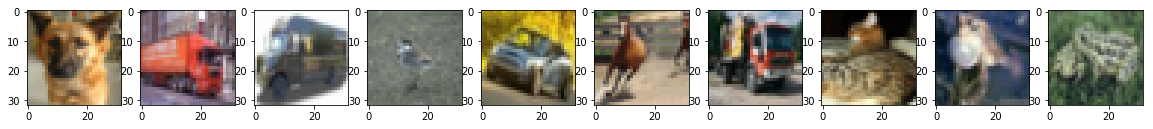

In [16]:
def draw(data, row, col, n):
    plt.subplot(row, col, n)    
    plt.imshow(data)
    
show_size = 10
plt.figure(figsize=(20,20))
for i in range(show_size):
    draw(X_train[i], 1, show_size, i+1)
plt.show()

### Make Prediction Based on the Model and Visualize the Results

In [48]:
y_pred_labels = model.predict_classes(X_test)
y_pred = np_utils.to_categorical(y_pred_labels, nb_classes)
y_pred = y_pred.astype(int)

 9984/10000 [============================>.] - ETA: 0s

### Incorrect Results

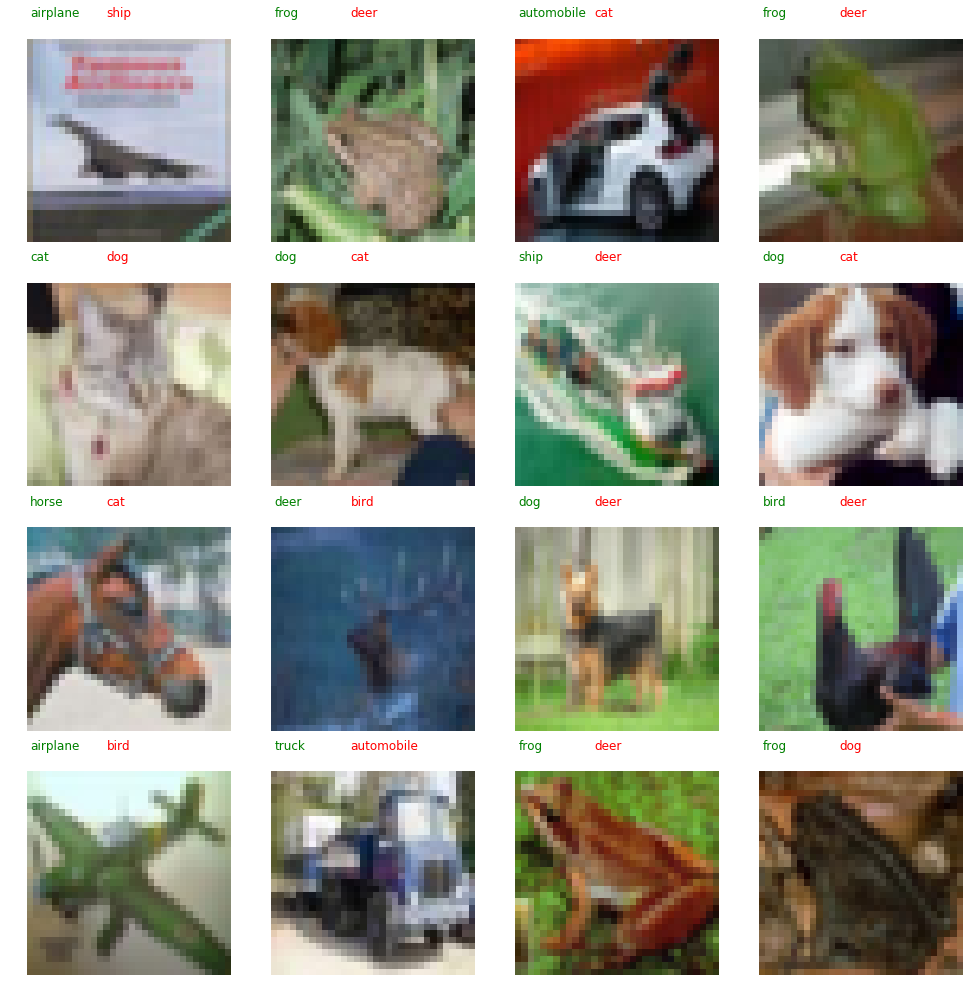

In [49]:
test_wrong = [im for im in zip(X_test,y_pred_labels,y_test_labels) if im[1] != im[2]]

plt.figure(figsize=(13, 13))
for ind, val in enumerate(test_wrong[:16]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.subplot(4, 4, ind + 1)
    im = val[0]#.reshape((32,32))
    plt.axis("off")
    plt.text(0, -4, class_names[val[2]], fontsize=12, color='green')
    plt.text(12, -4, class_names[val[1]], fontsize=12, color='red')
    plt.imshow(im, cmap='gray')

### Correct results

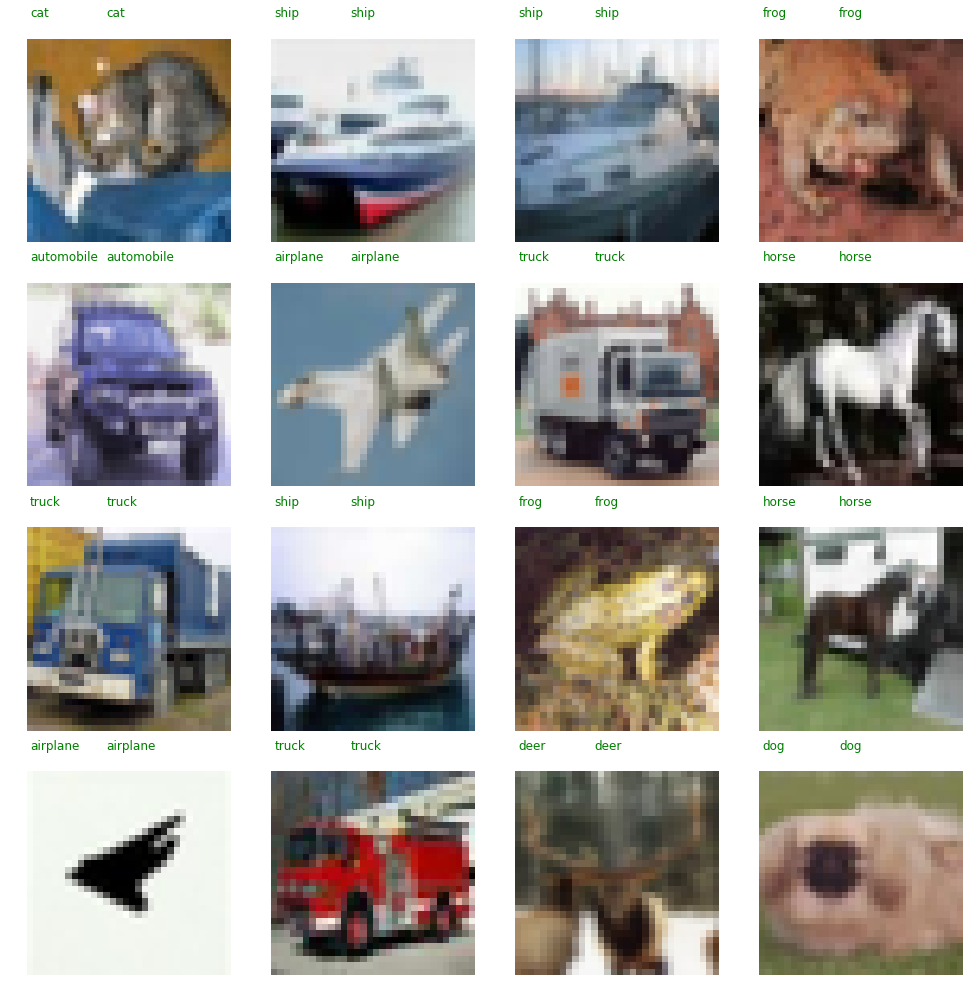

In [50]:
test_right = [im for im in zip(X_test,y_pred_labels,y_test_labels) if im[1] == im[2]]

plt.figure(figsize=(13, 13))
for ind, val in enumerate(test_right[:16]):
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.subplot(4, 4, ind + 1)
    im = val[0]#.reshape((32,32))
    plt.axis("off")
    plt.text(0, -4, class_names[val[2]], fontsize=12, color='green')
    plt.text(12, -4, class_names[val[1]], fontsize=12, color='green')
    plt.imshow(im, cmap='gray')

### Plot Confusion Matrix and Classification Report

Detailed classification report:

             precision    recall  f1-score   support

          0       0.58      0.57      0.58      1000
          1       0.85      0.39      0.54      1000
          2       0.37      0.43      0.40      1000
          3       0.32      0.42      0.37      1000
          4       0.37      0.57      0.45      1000
          5       0.39      0.61      0.47      1000
          6       0.73      0.40      0.51      1000
          7       0.69      0.42      0.52      1000
          8       0.56      0.69      0.62      1000
          9       0.74      0.43      0.54      1000

avg / total       0.56      0.49      0.50     10000


[575  10 115  38  44  23   8  11 163  13] (0) airplane
[102 393  56  78  37  29  30  17 143 115] (1) automobile
[ 49   1 430 103 218 132  27  21  17   2] (2) bird
[ 13   0 120 425  96 287  25  12  18   4] (3) cat
[ 22   0 129  90 569 119  21  39  11   0] (4) deer
[ 13   0  83 183  80 607   5  17  11   1] (5) dog
[  1   0  66 

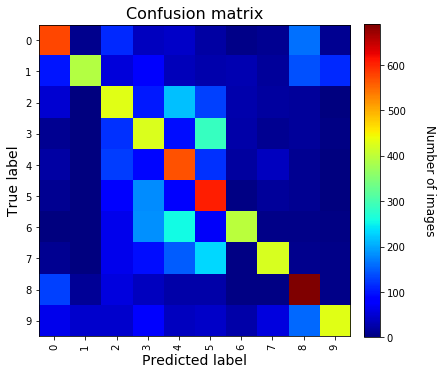

In [25]:
def plot_confusion_matrix(y_true, y_pred, nb_classes, class_names):
    cm = confusion_matrix(y_true,y_pred)
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.jet)
    plt.title("Confusion matrix", fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
    xtick_marks = np.arange(len(true_labels))
    ytick_marks = np.arange(len(pred_labels))
    plt.xticks(xtick_marks, true_labels, rotation=90)
    plt.yticks(ytick_marks,pred_labels)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 6
    fig_size[1] = 6
    plt.rcParams["figure.figsize"] = fig_size
    
    print()
    
    # Print the confusion matrix as text.
    for i in range(nb_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(nb_classes)]
    print("".join(class_numbers))

print("Detailed classification report:")
print()
print(classification_report(y_test_labels, y_pred_labels))
plot_confusion_matrix(y_test_labels, y_pred_labels,  nb_classes, class_names)

### Visualizing the Convolutinal Weights

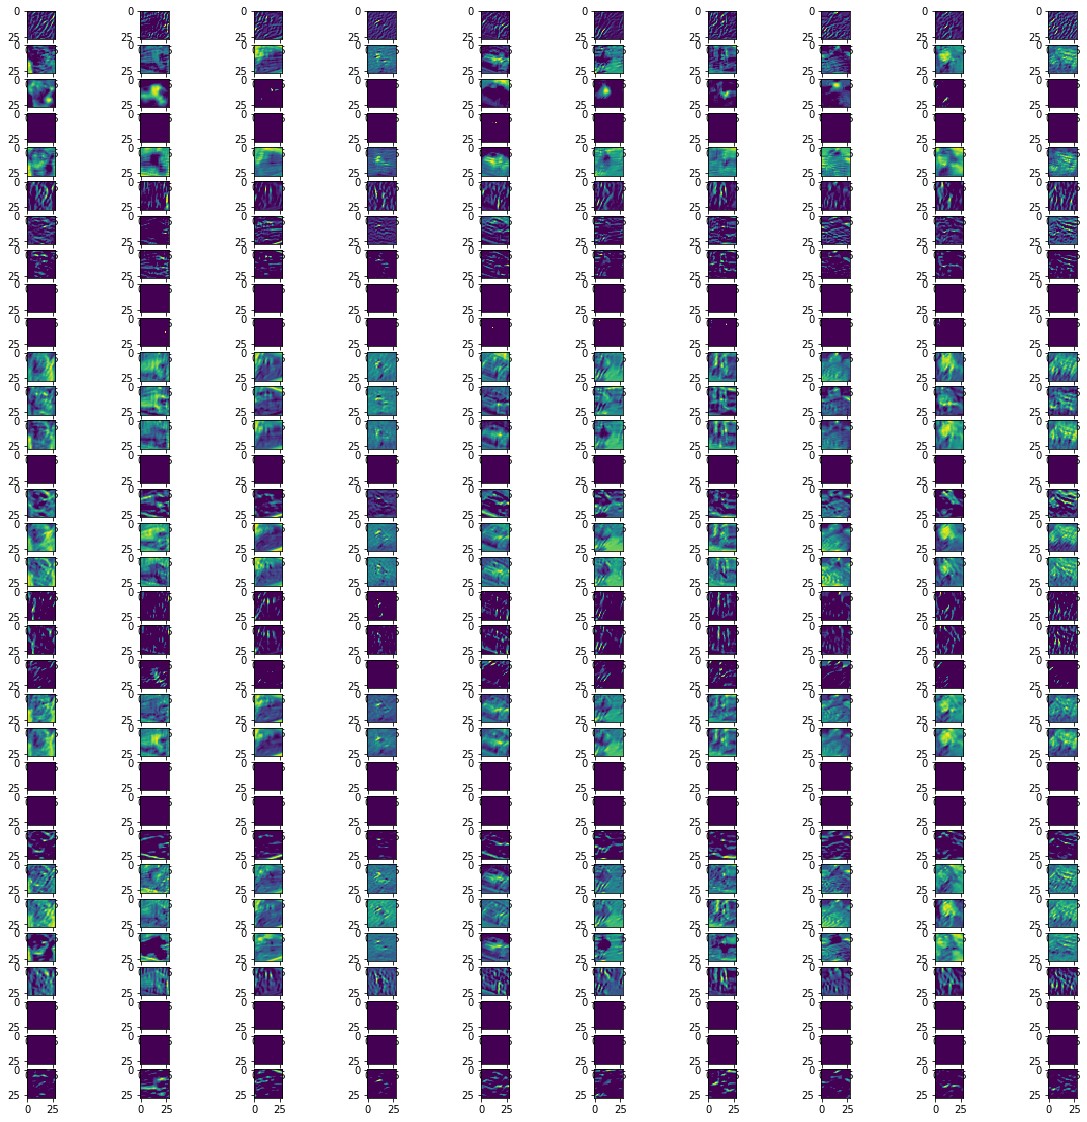

In [24]:
layer_output = k.function([model.layers[0].input],
                          [model.layers[1].output])
layers = layer_output([X_train[0:show_size]])[0].transpose(0, 3, 1, 2)

plt.figure(figsize=(20, 20))

for img_index, filters in enumerate(layers, start=1):
    for filter_index, mat in enumerate(filters):
        pos = (filter_index)*show_size+img_index
        draw(mat, nb_filter, show_size, pos)
plt.show()